In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from dataclasses import dataclass

@dataclass
class Signal:
    amp: float
    freq: float
    phase: float = 0.0
    
    def sample(self, timeArray):
        return self.amp * np.cos(2 * np.pi * self.freq * timeArray + self.phase)

def generateWaveForm(inputSignalArray, sampleFreq, totalTime):
    samplePeriod = 1 / sampleFreq
    timeArray = np.arange(0, totalTime, samplePeriod)
    
    outputSignalArray = np.zeros_like(timeArray)
    
    for signal in inputSignalArray:
        outputSignalArray += signal.sample(timeArray)
    
    return outputSignalArray
    

mean = 0
sigma = 0.5

sampleFreq = 50_000
samplePeriod = 1 / sampleFreq
totalTime = 5

signalList = [Signal(1, 200)]

waveFreq = signalList[0].freq
amp = signalList[0].amp

signal = generateWaveForm(signalList, sampleFreq, totalTime)

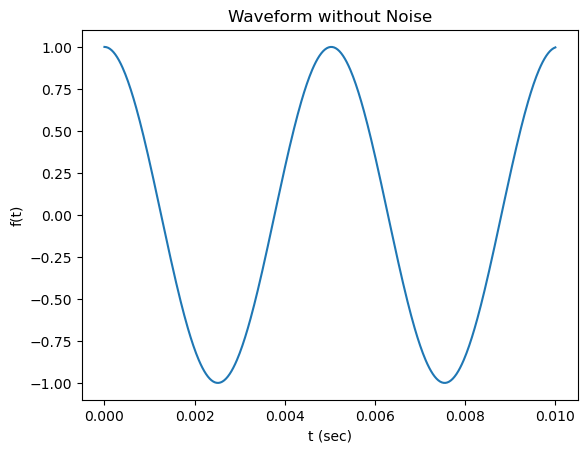

In [2]:
interval = (1 / waveFreq) / samplePeriod
interval = math.floor(interval)
numPeriods = 2

x = np.linspace(0, (1 / waveFreq) * numPeriods, interval * numPeriods)
y = signal

plt.plot(x, y[0 : interval * numPeriods])

plt.xlabel("t (sec)")
plt.ylabel(f"f(t)")
plt.title("Waveform without Noise")

plt.show()

In [3]:
noisySignalSmall = signal.copy()
noisySignalMedium = signal.copy()
noisySignalLarge = signal.copy()

#to control how noisy the signal is A/sigma >> 1 for less noisy
SNRFactor = 1 / 5
mean = 0
sigma = amp * SNRFactor

for k in range(len(signal)):
     noisySignalSmall[k] += random.gauss(mean, sigma * sigma)

SNRFactor = 1 / 1
mean = 0
sigma = amp * SNRFactor
        
for k in range(len(signal)):
     noisySignalMedium[k] += random.gauss(mean, sigma * sigma)

SNRFactor = 1 / 0.25
mean = 0
sigma = amp * SNRFactor

for k in range(len(signal)):
     noisySignalLarge[k] += random.gauss(mean, sigma * sigma)

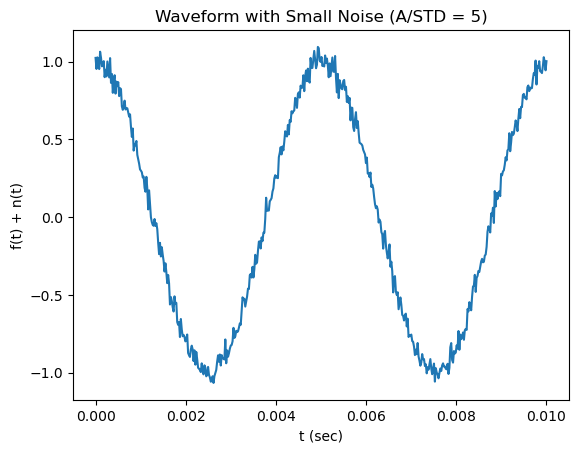

In [4]:
xNoiseSmall = np.linspace(0, (1 / waveFreq) * numPeriods, interval * numPeriods)
yNoiseSmall = noisySignalSmall

plt.plot(xNoiseSmall, yNoiseSmall[0 : interval * numPeriods])

plt.xlabel("t (sec)")
plt.ylabel(f"f(t) + n(t)")
plt.title("Waveform with Small Noise (A/STD = 5)")

plt.show()

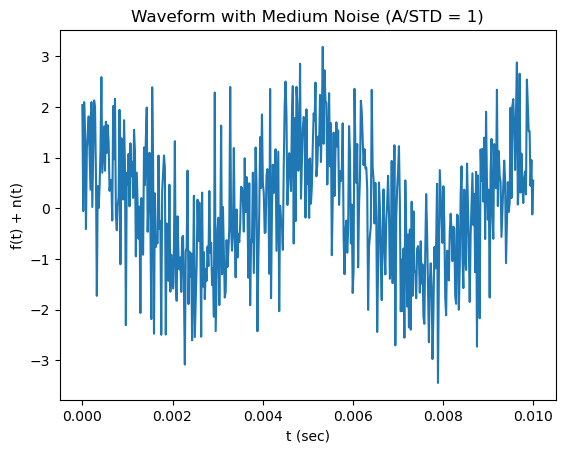

In [5]:
xNoiseMedium = np.linspace(0, (1 / waveFreq) * numPeriods, interval * numPeriods)
yNoiseMedium = noisySignalMedium

plt.plot(xNoiseMedium, yNoiseMedium[0 : interval * numPeriods])

plt.xlabel("t (sec)")
plt.ylabel(f"f(t) + n(t)")
plt.title("Waveform with Medium Noise (A/STD = 1)")

plt.show()

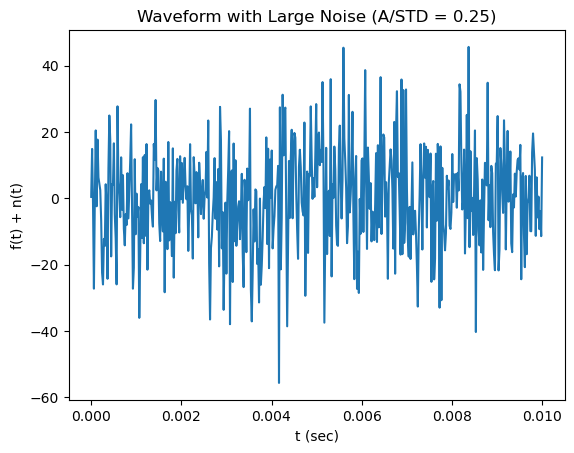

In [6]:
xNoiseLarge = np.linspace(0, (1 / waveFreq) * numPeriods, interval * numPeriods)
yNoiseLarge = noisySignalLarge

plt.plot(xNoiseLarge, yNoiseLarge[0 : interval * numPeriods])

plt.xlabel("t (sec)")
plt.ylabel(f"f(t) + n(t)")
plt.title("Waveform with Large Noise (A/STD = 0.25)")

plt.show()

In [7]:
noisySignalSmallWindow = list()
noisySignalSmallWindow = noisySignalSmall.copy()
noisySignalMediumWindow = noisySignalMedium.copy()
noisySignalLargeWindow = noisySignalLarge.copy()

hannWeight = np.hanning(len(noisySignalSmallWindow))

noisySignalSmallWindow = noisySignalSmallWindow * hannWeight
noisySignalMediumWindow = noisySignalMediumWindow * hannWeight
noisySignalLargeWindow = noisySignalLargeWindow * hannWeight

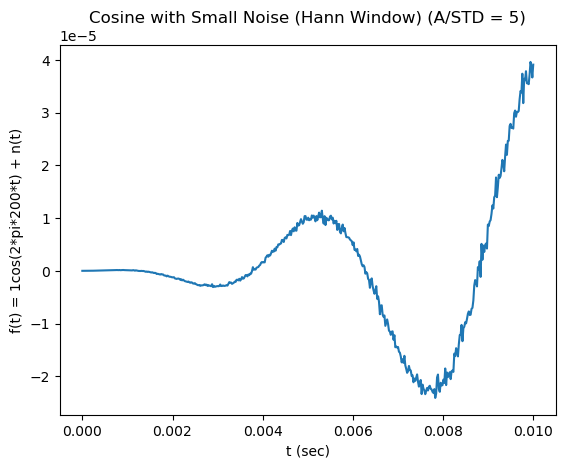

In [8]:
xNoiseSmall = np.linspace(0, (1 / waveFreq) * numPeriods, interval * numPeriods)
yNoiseSmallWindow = noisySignalSmallWindow

plt.plot(xNoiseSmall, yNoiseSmallWindow[0 : interval * numPeriods])

plt.xlabel("t (sec)")
plt.ylabel(f"f(t) = {amp}cos(2*pi*{waveFreq}*t) + n(t)")
plt.title("Cosine with Small Noise (Hann Window) (A/STD = 5)")

plt.show()

In [9]:
Fs = 1000
#in hz

#this is used to downsample the frequency.
#Creates an index array for the FFT
arrayStep = range(0, len(signal), (int)(len(signal) / (totalTime / (1 / Fs))))

downSampleSmall = noisySignalSmallWindow[arrayStep]
downSampleMedium = noisySignalMediumWindow[arrayStep]
downSampleLarge = noisySignalLargeWindow[arrayStep]

x_small = np.asarray(downSampleSmall)
x_medium = np.asarray(downSampleMedium)
x_large = np.asarray(downSampleLarge)
N = len(x_small)

X_small = np.fft.rfft(x_small)
X_medium = np.fft.rfft(x_medium)
X_large = np.fft.rfft(x_large)

freqArray = np.fft.rfftfreq(N, 1 / Fs)

X_small_mag = np.abs(X_small) / N
X_medium_mag = np.abs(X_medium) / N
X_large_mag = np.abs(X_large) / N

X_small_mag[1:-1] *= 2
X_medium_mag[1:-1] *= 2
X_large_mag[1:-1] *= 2

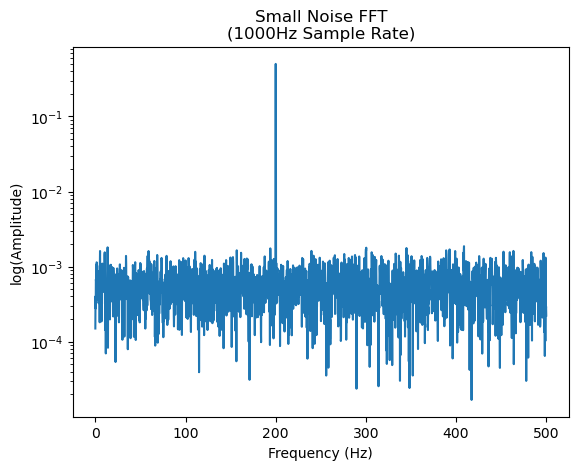

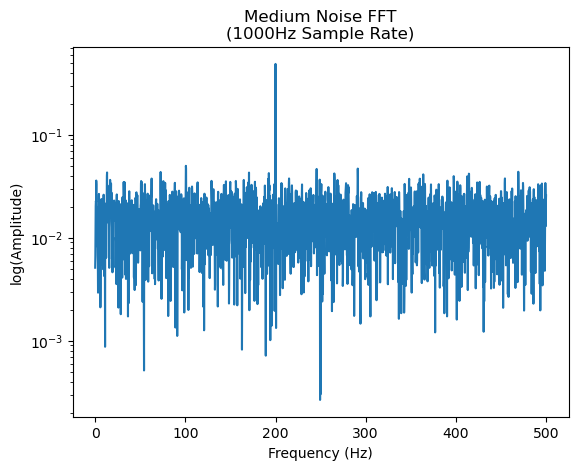

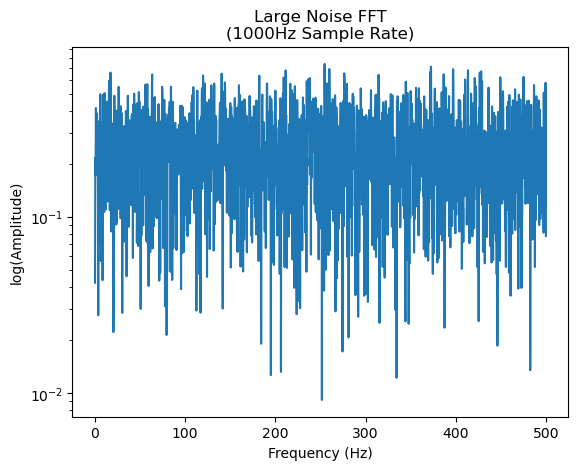

In [10]:
plt.semilogy(freqArray, X_small_mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("log(Amplitude)")
plt.title(f"Small Noise FFT\n({Fs}Hz Sample Rate)")
plt.show()

plt.semilogy(freqArray, X_medium_mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("log(Amplitude)")
plt.title(f"Medium Noise FFT\n({Fs}Hz Sample Rate)")
plt.show()

plt.semilogy(freqArray, X_large_mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("log(Amplitude)")
plt.title(f"Large Noise FFT\n({Fs}Hz Sample Rate)")
plt.show()

In [11]:
'''
Going to demonstrate the idea of aliasing:
A signal sampled at less than double its frequency will alias
Nyquist theorom says that the maximum samplable frequency is 1/2 the sample rate

anything higher will appear as a modulation of the sample frequency
I.E. if a 1100 Hz signal is sampled at 1000 Hz, it will be reflect as a peak in the FFT at 100 Hz.
'''

'\nGoing to demonstrate the idea of aliasing:\nA signal sampled at less than double its frequency will alias\nNyquist theorom says that the maximum samplable frequency is 1/2 the sample rate\n\nanything higher will appear as a modulation of the sample frequency\nI.E. if a 1100 Hz signal is sampled at 1000 Hz, it will be measured at 100 Hz.\n'

In [12]:
sampleFreq = 50_000
totalTime = 5

signalList = [Signal(1, 200), Signal(1, 1100)]
signalWaveForm = generateWaveForm(signalList, sampleFreq, totalTime)

SNRFactor = 1 / 1
mean = 0
sigma = signalList[0].amp * SNRFactor

signalWaveForm += np.random.normal(mean, sigma * sigma, len(signalWaveForm))

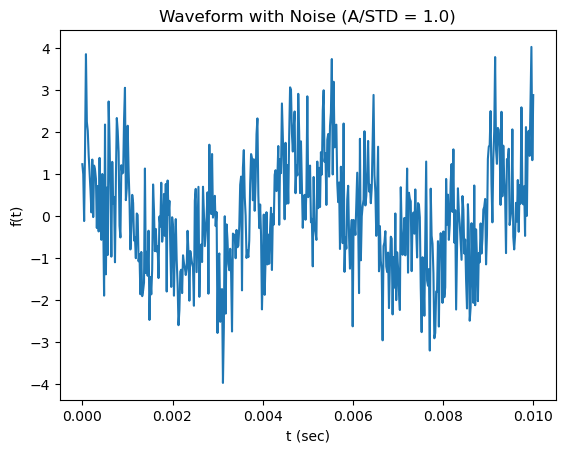

In [13]:
waveFreq = signalList[0].freq
amp = signalList[0].amp

interval = (1 / waveFreq) / (1 / sampleFreq)
interval = math.floor(interval)
numPeriods = 2

x = np.linspace(0, (1 / waveFreq) * numPeriods, interval * numPeriods)
y = signalWaveForm

plt.plot(x, y[0 : interval * numPeriods])

plt.xlabel("t (sec)")
plt.ylabel(f"f(t)")
plt.title(f"Waveform with Noise (A/STD = {SNRFactor})")

plt.show()

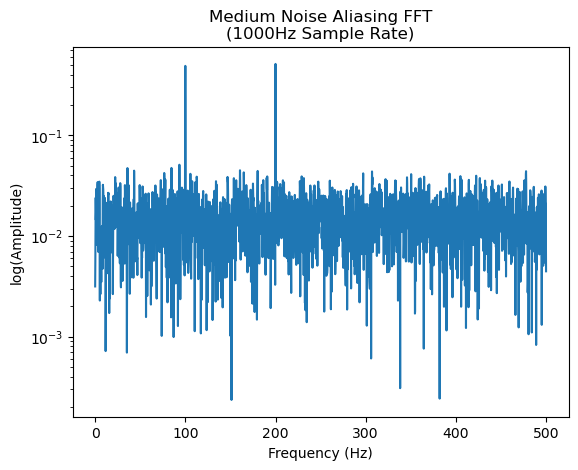

In [14]:
Fs = 1000

hannWeight = np.hanning(len(signalWaveForm))
signalWaveForm *= hannWeight

arrayStep = range(0, len(signalWaveForm), (int)(len(signalWaveForm) / (totalTime / (1 / Fs))))

downSample = signalWaveForm[arrayStep]

X = np.fft.rfft(downSample)
X_mag = np.abs(X) / len(downSample)

freqBin = np.fft.rfftfreq(len(downSample), 1 / Fs)
X_mag[1:-1] *= 2

plt.semilogy(freqBin, X_mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("log(Amplitude)")
plt.title(f"Medium Noise Aliasing FFT\n({Fs}Hz Sample Rate)")
plt.show()

In [15]:
'''
In this plot, the aliasing due to the 1100 Hz signal sampled at 1000 Hz can be seen via the peak at 100 Hz
'''

'\nIn this plot, the aliasing due to the 1100 Hz signal sampled at 1000 Hz can be seen via the peak at 100 Hz\n'